In [1]:
import os
from sklearn.datasets import fetch_mldata
import random
import torch
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn as nn
import torch.nn.parallel
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cv2
import numpy as np

torch.cuda.set_device(0)


In [5]:
""" ==================== DATASET ======================== """

def dataset_img_resize():
    X_train = np.zeros(0)
    root_dir = '/home/hubo/notebook/data/tumor/'
    imageList = os.listdir(root_dir)
    m = 0
    print (imageList)
    for n in imageList:
        n = root_dir + n
        print (n)
        img = cv2.imread(n, 3)
        hight, width = 0,0
        q = 1

        while hight+64 < img.shape[0]:
            while width+64 < img.shape[1]:
                resize = cv2.resize(img[hight:hight+64,width:width+64,:],(64,64))
                resize = resize[:,:,::-1].transpose((2,0,1))
                resize = resize.astype(np.float32)/(255.0/2) - 1.0
                resize = resize.reshape((1, 3, 64, 64))
                width = width+64
                q+=1
                if X_train.shape[0] == 0:
                    X_train = resize.reshape((1,1,3,64,64)).astype(np.float32)
                else:
                    X_train = np.concatenate((X_train,resize.reshape((1,1,3,64,64))),axis=0)
                    #print (X_train.shape)
            hight = hight+64
            width = 0
            
    np.random.seed(1234) # set seed for deterministic ordering
    p = np.random.permutation(X_train.shape[0])
    X_train = X_train[p]
    return X_train

X_train = dataset_img_resize()
X_train.shape

['path-image-116.tif', 'path-image-129.tif', 'path-image-119.tif', 'path-image-128.tif', 'path-image-103.tif', 'path-image-100.tif', 'path-image-120.tif', 'path-image-104.tif', 'path-image-111.tif', 'path-image-132.tif', 'path-image-123.tif', 'path-image-107.tif', 'path-image-109.tif', 'path-image-117.tif', 'path-image-115.tif', 'path-image-121.tif', 'path-image-108.tif', 'path-image-122.tif', 'path-image-131.tif', 'path-image-130.tif', 'path-image-127.tif', 'path-image-114.tif', 'path-image-112.tif', 'path-image-118.tif', 'path-image-106.tif', 'path-image-110.tif', 'path-image-124.tif', 'path-image-133.tif', 'path-image-101.tif', 'path-image-134.tif', 'path-image-125.tif', 'path-image-113.tif']
/home/hubo/notebook/data/tumor/path-image-116.tif
/home/hubo/notebook/data/tumor/path-image-129.tif


KeyboardInterrupt: 

In [ ]:
X_train = Variable(torch.FloatTensor(X_train))
train_loader = torch.utils.data.TensorDataset(X_train,X_train)
dataiter = iter(train_loader)

In [5]:
def visual(X):
    assert len(X.shape) == 4
    X = X.transpose((0, 2, 3, 1))
    X = (X+1.0)*(255.0/2.0)
    X = X.reshape(X.shape[1],X.shape[2],X.shape[3])
 #   X = X[:,:,::-1]
    return np.uint8(X) #  cv2.waitKey(1)

def fill_buf(buf, i, img, shape):
    n = buf.shape[0]/shape[1]
    m = buf.shape[1]/shape[0]

    sx = (i%m)*shape[0]
    sy = (i/m)*shape[1]
    buf[sy:sy+shape[1], sx:sx+shape[0], :] = img


In [ ]:
img,_ = dataiter.next()
img = img.data.numpy()

X = visual(img)
plt.imshow(X)

In [ ]:
#images, labels = dataiter.next()
#visual('qqq', images.data.numpy())

In [ ]:
mb_size = 32
Z_dim = 16
X_dim = 64
y_dim = 64
h_dim = 128
cnt = 0
lr = 1e-3

In [ ]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

In [6]:
""" ==================== GENERATOR ======================== """
import torch.nn.parallel

class _netG(nn.Module):
    def __init__(self, ngpu, isize = 64, nz = 149, nc = 3, ngf = 64, n_extra_layers=0):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize != isize:
            cngf = cngf * 2
            tisize = tisize * 2

        main = nn.Sequential()
        # input is Z, going into a convolution
        main.add_module('initial.{0}-{1}.convt'.format(nz, cngf),
                        nn.ConvTranspose2d(nz, cngf, 4, 1, 0, bias=False))
        main.add_module('initial.{0}.batchnorm'.format(cngf),
                        nn.BatchNorm2d(cngf))
        main.add_module('initial.{0}.relu'.format(cngf),
                        nn.ReLU(True))

        csize, cndf = 4, cngf
        while csize < isize//2:
            main.add_module('pyramid.{0}-{1}.convt'.format(cngf, cngf//2),
                            nn.ConvTranspose2d(cngf, cngf//2, 4, 2, 1, bias=False))
            main.add_module('pyramid.{0}.batchnorm'.format(cngf//2),
                            nn.BatchNorm2d(cngf//2))
            main.add_module('pyramid.{0}.relu'.format(cngf//2),
                            nn.ReLU(True))
            cngf = cngf // 2
            csize = csize * 2

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}.{1}.conv'.format(t, cngf),
                            nn.Conv2d(cngf, cngf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}.{1}.batchnorm'.format(t, cngf),
                            nn.BatchNorm2d(cngf))
            main.add_module('extra-layers-{0}.{1}.relu'.format(t, cngf),
                            nn.ReLU(True))

        main.add_module('final.{0}-{1}.convt'.format(cngf, nc),
                        nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        main.add_module('final.{0}.tanh'.format(nc),
                        nn.Tanh())
        self.main = main

    def forward(self, input):
        gpu_ids = None
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            gpu_ids = range(self.ngpu)
        return self.main(input)
    
#noise = Variable(torch.randn(1, 74))
netG = _netG(6)
print (netG)
#netG(noise)


_netG (
  (main): Sequential (
    (initial.149-512.convt): ConvTranspose2d(149, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (initial.512.batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (initial.512.relu): ReLU (inplace)
    (pyramid.512-256.convt): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.256.batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (pyramid.256.relu): ReLU (inplace)
    (pyramid.256-128.convt): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.128.batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (pyramid.128.relu): ReLU (inplace)
    (pyramid.128-64.convt): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.64.batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (pyramid.64.relu): ReLU (inplace)
    (final.64-3.convt): Co

In [7]:
""" ==================== DISCRIMINATOR  ======================== """

class _netD(nn.Module):
    def __init__(self, isize = 64, nz = 149, nc = 3, ndf = 64, ngpu = 6, n_extra_layers=0):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        main = nn.Sequential()
        # input is nc x isize x isize
        main.add_module('initial.conv.{0}-{1}'.format(nc, ndf),
                        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False))
        main.add_module('initial.relu.{0}'.format(ndf),
                        nn.LeakyReLU(0.2, inplace=True))
        csize, cndf = isize / 2, ndf

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}.{1}.conv'.format(t, cndf),
                            nn.Conv2d(cndf, cndf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}.{1}.batchnorm'.format(t, cndf),
                            nn.BatchNorm2d(cndf))
            main.add_module('extra-layers-{0}.{1}.relu'.format(t, cndf),
                            nn.LeakyReLU(0.2, inplace=True))

        while csize > 4:
            in_feat = cndf
            out_feat = cndf * 2
            main.add_module('pyramid.{0}-{1}.conv'.format(in_feat, out_feat),
                            nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False))
            main.add_module('pyramid.{0}.batchnorm'.format(out_feat),
                            nn.BatchNorm2d(out_feat))
            main.add_module('pyramid.{0}.relu'.format(out_feat),
                            nn.LeakyReLU(0.2, inplace=True))
            cndf = cndf * 2
            csize = csize / 2

        # state size. K x 4 x 4
       # main.add_module('final.{0}-{1}.conv'.format(cndf, 1),
       #                 nn.Conv2d(cndf, 1, 4, 1, 0, bias=False))
        self.main = main
        
    def forward(self, input):
        gpu_ids = None
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            gpu_ids = range(self.ngpu)
        return self.main(input)


netD = _netD()
#print (netD)

generate = Variable(torch.zeros(1,3,64,64))
#print netD(generate)

In [8]:
class _netD_D(nn.Module):
    def __init__(self):
        super(_netD_D, self).__init__()
        self.conv = nn.Conv2d(512, 1, 4, 1, 0, bias=False)
        
    def forward(self, x):
        x = self.conv(x)
        return x
    
class _netD_Q(nn.Module):
    def __init__(self):
        super(_netD_Q, self).__init__()
        # input is Z, going into a convolution
        self.conv = nn.Conv2d(512, 10, 4, 1, 0, bias=False)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(1,-1)
        x = self.softmax(x)
     #   x = x.view(1,-1,1,1)
        return x
    
class _netD_Q_2(nn.Module):
    def __init__(self):
        super(_netD_Q_2, self).__init__()
        # input is Z, going into a convolution
        self.conv = nn.Conv2d(512, 10, 4, 1, 0, bias=False)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(1,-1)
        x = self.softmax(x)
     #   x = x.view(1,-1,1,1)
        return x

class _netD_Q_3(nn.Module):
    def __init__(self):
        super(_netD_Q_3, self).__init__()
        # input is Z, going into a convolution
        self.conv = nn.Conv2d(512, 1, 4, 1, 0, bias=False)
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(1,-1)
        return x

    
netD_D = _netD_D()
netD_Q = _netD_Q()
netD_Q_2 = _netD_Q_2()
netD_Q_3 = _netD_Q_3()


print (netD_D)
print (netD_Q)
#output = netD(x,'D')
#output
generate = Variable(torch.zeros(1,3,64,64))
netD_Q(netD(generate)).size()

_netD_D (
  (conv): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)
_netD_Q (
  (conv): Conv2d(512, 10, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (softmax): Softmax ()
)


torch.Size([1, 10])

In [ ]:
""" ==================== DISCRIMINATOR  ======================== 
class _netD_D(nn.Module):
    def __init__(self):
        super(_netD_D, self).__init__()
        self.fc2 = nn.Linear(1024, 1)
        
    def forward(self, x):
        x = self.fc2(x)
      #  x = x.sigmoid()
        x = x.view(-1)
        return x
    
class _netD_Q(nn.Module):
    def __init__(self):
        super(_netD_Q, self).__init__()
        # input is Z, going into a convolution
        self.fc4 = nn.Linear(1024, 10)
        
    def forward(self, x):
        x = self.fc4(x)
      #  x = x.sigmoid()
        return x
    
netD_D = _netD_D()
netD_Q = _netD_Q()

print (netD_D)
print (netD_Q)
#output = netD(x,'D')
#output

"""

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
   # print (classname)
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        print (classname)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        print (classname)

netG.apply(weights_init)
netD.apply(weights_init)
netD_Q.apply(weights_init)
netD_Q_2.apply(weights_init)
netD_Q_3.apply(weights_init)
netD_D.apply(weights_init)


ConvTranspose2d
BatchNorm2d
ConvTranspose2d
BatchNorm2d
ConvTranspose2d
BatchNorm2d
ConvTranspose2d
BatchNorm2d
ConvTranspose2d
Conv2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
Conv2d
Conv2d
Conv2d


_netD_D (
  (conv): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

In [7]:
""" ====================== OPTIMISER ========================== """

optimizerD = optim.RMSprop([
                {'params': netD.parameters()},
                {'params': netD_D.parameters()}
            ], 0.00005)

optimizerG = optim.RMSprop(netG.parameters(), lr = 0.00005)

optimizerQ = optim.RMSprop([
                {'params': netG.parameters()},            
                {'params': netD.parameters()},
                {'params': netD_Q.parameters()},
                {'params': netD_Q_2.parameters()},
                {'params': netD_Q_3.parameters()}
            ], 0.00005)



In [8]:
input = torch.FloatTensor(1, 3, 64, 64)
noise = torch.FloatTensor(1, 149,1 ,1 )

fixed_noise = torch.FloatTensor(np.random.multinomial(1, 10*[0.1], size=1))
c = torch.FloatTensor(np.random.multinomial(1, 10*[0.1], size=1))
c2 = torch.FloatTensor(np.random.multinomial(1, 10*[0.1], size=1))
c3 = torch.FloatTensor(np.random.uniform(-1,1,(1,1)))
z = torch.randn(1, 128,1,1)

label = torch.FloatTensor(1)

real_label = 1
fake_label = 0


In [9]:
c3.uniform_(-1,1)


-0.2858
[torch.FloatTensor of size 1x1]

In [10]:
criterion = nn.BCELoss()
criterion_logli = nn.NLLLoss()
criterion_mse = nn.MSELoss()

In [11]:
netD = netD.cuda()
netG = netG.cuda()
netD_D = netD_D.cuda()
netD_Q = netD_Q.cuda()
netD_Q_2 = netD_Q_2.cuda()
netD_Q_3 = netD_Q_3.cuda()
criterion, criterion_logli, criterion_mse = criterion.cuda(), criterion_logli.cuda(), criterion_mse.cuda()
input, label = input.cuda(), label.cuda()
noise, fixed_noise = noise.cuda(), fixed_noise.cuda()
z, c, c2, c3 = z.cuda(), c.cuda(), c2.cuda(), c3.cuda()

In [ ]:
input = Variable(input)
label = Variable(label)
noise = Variable(noise)
fixed_noise = Variable(fixed_noise)
c = Variable(c)
c2 = Variable(c2)
c3 = Variable(c3)
z = Variable(z)

In [12]:
""" ======================TRAIN========================== """

def sample_c():
    rand_c = np.random.multinomial(1, 10*[0.1], size=1)
    rand_c = torch.from_numpy(rand_c.astype('float32'))
    return rand_c

def zero_grad():
    netD.zero_grad()
    netD_Q.zero_grad()
    netD_Q_2.zero_grad()
    netD_Q_3.zero_grad()
    netD_D.zero_grad()
    netG.zero_grad()

In [ ]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

one = torch.FloatTensor([1]).cuda()
mone = one * -1
mone = mone.cuda()
gen_iterations = 0

for epoch in range(100000):
    
    dataiter = iter(train_loader)
    i = 0
    
    while i < len(train_loader):
        for p in netD.parameters():
            p.data.clamp_(-0.01, 0.01)
        for p in netD_D.parameters():
            p.data.clamp_(-0.01, 0.01)

        if gen_iterations < 25 or gen_iterations % 500 == 0:
            Diters = 1
        else:
            Diters = 1
        
        j = 0
        while j < Diters and i < len(train_loader):
            j += 1
            image_, _ = dataiter.next()
            i +=1
            for p in netD.parameters():
                p.data.clamp_(-0.01, 0.01)
            for p in netD_D.parameters():
                p.data.clamp_(-0.01, 0.01)
    #train on D
    #sending real data 
            zero_grad()
            input.data.copy_(image_.data)
            label.data.resize_(1).fill_(real_label)
            D_real =netD_D(netD(input))
            #D_loss_real = criterion(D_real, label)
            D_real.backward(one)

    #sending noise
            z.data.normal_(0, 1)
            c.data.copy_(sample_c())
            c2.data.copy_(sample_c())
            c3.data.uniform_(-1,1)
            noise = torch.cat([c,c2,c3,z],1)
        
            G_sample = netG(noise)
            D_fake = netD_D(netD(G_sample))
            label.data.resize_(1).fill_(fake_label)
           # D_loss_fake = criterion(D_fake, label)
            D_fake.backward(mone)
        
    # update D
            optimizerD.step()
    

    # update G  
        zero_grad()
        G_sample = netG(noise)
        D_fake = netD_D(netD(G_sample))
        label.data.resize_(1).fill_(real_label)
       # G_loss = criterion(D_fake, label)
        D_fake.backward(one)
        optimizerG.step()
        
        gen_iterations += 1
        
    # update Q
        zero_grad()
        G_sample = netG(noise)
        Q_c_given_x = netD_Q(netD(G_sample))
        Q_c_given_x_2 = netD_Q_2(netD(G_sample))
        Q_c_given_x_3 = netD_Q_3(netD(G_sample))
        
        crossent_loss = torch.mean(-torch.sum(c * torch.log(Q_c_given_x + 1e-8), dim=1))
       # print (Q_c_given_x)
        crossent_loss_2 = torch.mean(-torch.sum(c2 * torch.log(Q_c_given_x_2 + 1e-8), dim=1))
        crossent_loss_3 = criterion_mse(Q_c_given_x_3, c3) 

        # ent_loss = torch.mean(-torch.sum(c * torch.log(c + 1e-8), dim=1))
       # ent_loss_2 = torch.mean(-torch.sum(c2 * torch.log(c2 + 1e-8), dim=1))
       # ent_loss_3 = torch.mean(-torch.sum(c3 * torch.log(c3 + 1e-8), dim=1))

        mi_loss = crossent_loss + crossent_loss_2 + 0.1*crossent_loss_3

        mi_loss.backward()
        optimizerQ.step()
        
        if gen_iterations % 20 == 0 :
            input.data.copy_(image_.data)
            label.data.resize_(1).fill_(real_label)
            D_real =netD_D(netD(input))
            D_error = D_real - D_fake
            print (gen_iterations , -D_error.data[0],mi_loss.data[0])
            

    if epoch % 30 == 0:
        torch.save(netG.state_dict(), './20170302/info_s_cell_netG_epoch_%d.pth' % (epoch))
        torch.save(netD.state_dict(), './20170302/info_s_cell_netD_epoch_%d.pth' % (epoch))
        torch.save(netD_D.state_dict(), './20170302/info_s_cell_netD_D_epoch_%d.pth' % (epoch))
        torch.save(netD_Q.state_dict(), './20170302/info_s_cell_netD_Q_epoch_%d.pth' % (epoch))


In [ ]:
crossent_loss_3 = criterion_mse(Q_c_given_x_3, c3) 

In [ ]:
netD_Q_2(netD(G_sample))


In [ ]:
netD_D(netD(input))

In [10]:
import math
import torch.nn.functional as F

class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        return torch.cat([x, out], 1)

class BottleneckBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BottleneckBlock, self).__init__()
        inter_planes = out_planes * 4
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, inter_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(inter_planes)
        self.conv2 = nn.Conv2d(inter_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        out = self.conv2(self.relu(self.bn2(out)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return torch.cat([x, out], 1)

class TransitionBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(TransitionBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return F.avg_pool2d(out, 2)

class DenseBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, growth_rate, block, dropRate=0.0):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, growth_rate, nb_layers, dropRate)
    def _make_layer(self, block, in_planes, growth_rate, nb_layers, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(in_planes+i*growth_rate, growth_rate, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class DenseNet3(nn.Module):
    def __init__(self, depth, num_classes, growth_rate=12,
                 reduction=0.5, bottleneck=True, dropRate=0.0):
        super(DenseNet3, self).__init__()
        in_planes = 2 * growth_rate
        n = (depth - 4) / 3
        if bottleneck == True:
            n = n/2
            block = BottleneckBlock
        else:
            block = BasicBlock
        # 1st conv before any dense block
        self.conv1 = nn.Conv2d(3, in_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans1 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        # 2nd block
        self.block2 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans2 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        # 3rd block
        self.block3 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(in_planes, num_classes)
        self.in_planes = in_planes

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.block1(out))
        out = self.trans2(self.block2(out))
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 16)
        out = out.view(-1, self.in_planes)
        return self.fc(out)

model = DenseNet3(100, 2, 12, reduction=0.5,
                         bottleneck=True, dropRate=0)
model.cuda()


DenseNet3 (
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): DenseBlock (
    (layer): Sequential (
      (0): BottleneckBlock (
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): BottleneckBlock (
        (bn1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (2): BottleneckBlock (
        (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affi

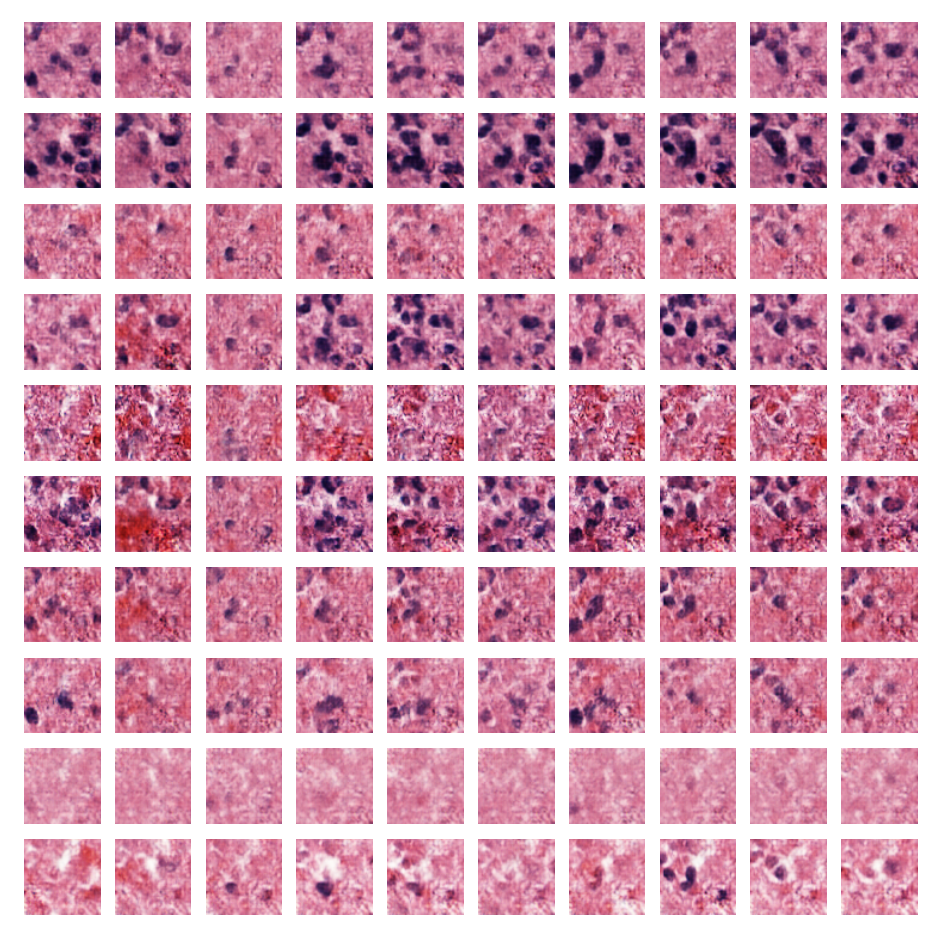

In [11]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

netG.cuda()
netG.load_state_dict(torch.load('./20170302/info_m_cell_netG_epoch_720.pth'))
model.load_state_dict(torch.load('./20170302/densenet_310.pth'))
plt.figure(num='output',figsize=(16,16))
z = Variable(torch.randn(1,128,1,1).cuda())
p1 = -1
p2 = -1
for k in range(0,10):
    p1+=1
    c1 = np.zeros((1,10),dtype = np.float32)
    c1[0,k] = 1
    c1 = Variable(torch.Tensor(c1).cuda())
    for q in range(0,10):
        p2+=1
        c2 = np.zeros((1,10),dtype = np.float32)
        c2[0,q] = 1
        c2 = Variable(torch.Tensor(c2).cuda())
        c3 = Variable(torch.Tensor(np.asarray([0],dtype=np.float32).reshape(1,1)).cuda())
        noise = torch.cat([c1,c2,c3,z],1)
        G_sample = netG(noise)
        image_output = visual(G_sample.data.cpu().numpy() )
        output = model(Variable(torch.Tensor(G_sample.data.cpu().numpy().astype(np.float32).reshape((1,3,64,64))).cuda()))
        plt.subplot(10,10,p1*10+p2+1) 
        plt.imshow(image_output)
        plt.title(np.array2string(output.data.cpu().numpy().reshape((2)),precision=1),color='white')
        plt.axis('off') 
    p2=-1

plt.show()

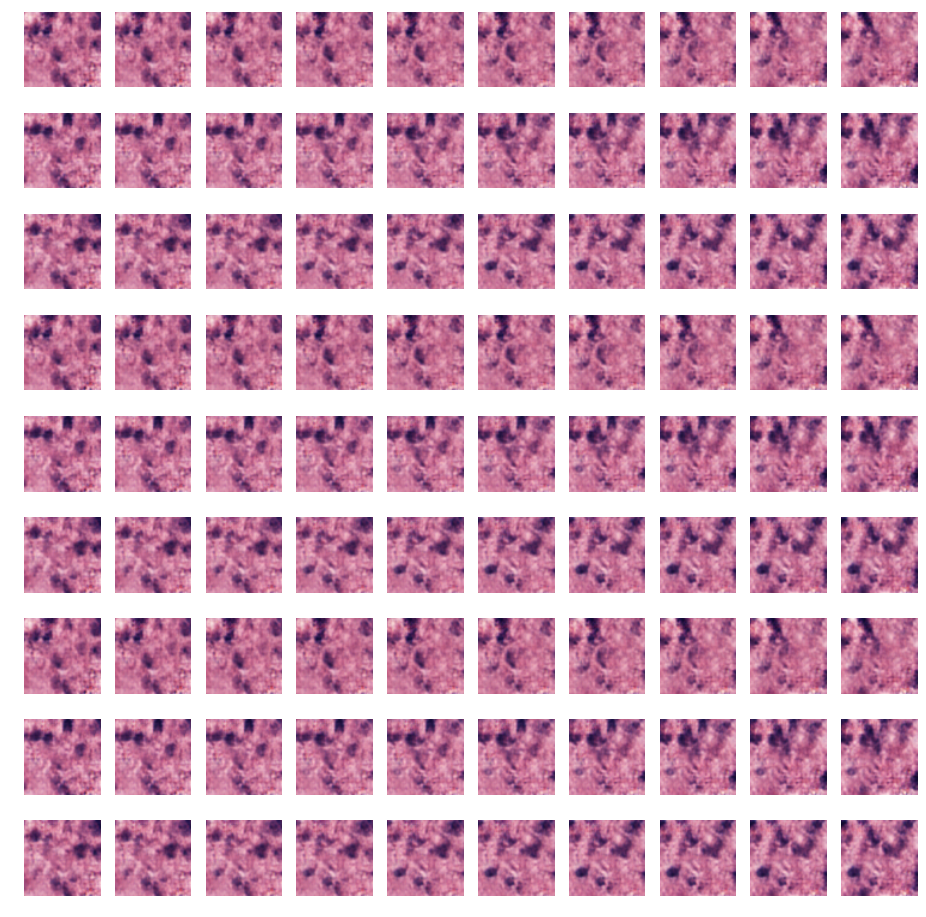

In [14]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

netG.cuda()
netG.load_state_dict(torch.load('./20170302/info_m_cell_netG_epoch_720.pth'))
plt.figure(num='output',figsize=(16,16))
z = Variable(torch.randn(1,128,1,1).cuda())
height = -1
for k in range(7,10):
    height +=1
    c1 = np.zeros((1,10),dtype = np.float32)
    c1[0,0] = 1
    c1 = Variable(torch.Tensor(c1).cuda())
    width = -1
    for q in range(7,10):
        width +=1
        c2 = np.zeros((1,10),dtype = np.float32)
        c2[0,q] = 1
        c2 = Variable(torch.Tensor(c2).cuda())
        for p in range(0,10):
            changing = (float(p)-5)/5*2
            #print (changing)
            c3 = Variable(torch.Tensor(np.asarray(changing,dtype=np.float32).reshape(1,1)).cuda())
            noise = torch.cat([c1,c2,c3,z],1)
            G_sample = netG(noise)
            image_output = visual(G_sample.data.cpu().numpy() )
            plt.subplot(9,10,height*10*3+width*10+p+1) 
            plt.imshow(image_output)     
            plt.axis('off') 

plt.show()

In [ ]:
noise

In [ ]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

netG.load_state_dict(torch.load('./20170227/info_s_cell_netG_epoch_210.pth'))

z = Variable(torch.randn(1,138,1,1).cuda())

for k in range(0,100):
        zero_grad()
        z.data.normal_(0, 1)
             #   c = sample_c()
        noise = z
        G_sample = netG(noise)
        image_output = visual(G_sample.data.cpu().numpy() )
        pl.figure(k+1)
        pl.imshow(image_output)
        pl.show()
